In [1]:
using Pkg
Pkg.activate("/Users/mathieu/Documents/AdaptiveTransportMap/")

 Activating environment at `~/Documents/AdaptiveTransportMap/Project.toml`


In [2]:
using Revise
using LinearAlgebra
using BenchmarkTools
using Statistics
using AdaptiveTransportMap
using JLD
using Test
using Plots

┌ Info: Precompiling AdaptiveTransportMap [bdf749b0-1400-4207-80d3-e689c0e3f03d]
└ @ Base loading.jl:1278
┌ Warning: Type annotations on keyword arguments not currently supported in recipes. Type information has been discarded
└ @ RecipesBase ~/.julia/packages/RecipesBase/92zOw/src/RecipesBase.jl:116


In [3]:
path = "/Users/mathieu/Documents/AdaptiveTransportMap/src/lorenz63/data/"
Nx = 3
Ny = 3
Ne = 100
β = sqrt(1.02)
@time model, data = setup_lorenz63(path, [Ne]);

Ne 100 RMSE: 0.33256976273435157
106.118761 seconds (131.33 M allocations: 7.659 GiB, 2.74% gc time)


In [13]:
Nx = 3
Ny = 3
Δtdyn = 0.05
Δtobs = 0.1

σx = 1e-2#1e-6#1e-2
σy = 2.0#1e-6#2.0

ϵx = AdditiveInflation(Nx, zeros(Nx), σx)
ϵy = AdditiveInflation(Ny, zeros(Ny), σy)
tspinup = 200.0
Tspinup = 2000
tmetric = 400.0
Tmetric = 4000
t0 = 0.0
tf = 600.0
Tf = 6000

Tburn = 2000
Tstep = 4000
Tspinup = 2000

m0 = zeros(Nx)
C0 = Matrix(1.0*I, Nx, Nx)

f = lorenz63!
h(t,x) = x
# Create a local version of the observation operator
# h(t,x,idx) = x[idx]

model = Model(Nx, Ny, Δtdyn, Δtobs, ϵx, ϵy, m0, C0, Tburn, Tstep, Tspinup, f, h);

# Set initial condition
x0 = model.m0 + sqrt(model.C0)*randn(Nx)
# x0 = [0.645811242103507;  -1.465126216973632;   0.385227725149822];

In [19]:
# Run dynamics and generate data
data = generate_lorenz63(model, x0, model.Tspinup+model.Tstep);

In [20]:
# Set initial condition
X = zeros(model.Ny + model.Nx, Ne)
X[model.Ny+1:model.Ny+model.Nx,:] .= sqrt(model.C0)*randn(model.Nx, Ne) .+ model.m0

J = model.Tspinup+model.Tstep
t0 = 0.0
dyn = DynamicalSystem(model.f, model.h)
enkf = StochEnKF(x->x, model.ϵy, model.Δtdyn, model.Δtobs, false, false)
enkf = ETKF(x->x, model.ϵy, model.Δtdyn, model.Δtobs, 50*model.Δtobs, false, false)

ETKF  with filtered = false


In [21]:
statehist = seqassim(dyn, data, J, model.ϵx, enkf, X, model.Ny, model.Nx, t0)

6001-element Array{Array{Float64,2},1}:
 [0.4642409593894176 1.003232100139568 … -0.47541286024289536 0.05723396556482702; 2.0817518248104037 0.6856275921481833 … -0.4651994658226963 1.1892715040515123; -0.3387894957155092 0.7281884626591741 … 0.10645399888383915 1.0616970840951523]
 [-1.3799649822988842 -2.3404163089901946 … -5.942884383788444 -3.1858534518687875; -2.8957188850883027 -4.770033933534216 … -12.653987920174504 -6.480371566011585; 6.05073424165426 4.279775880250974 … 2.254961439992049 2.9973610278341685]
 [-14.207371177293844 -16.68246023926355 … -16.812386014261623 -17.84696806412036; -3.3602886890516093 -7.022003192584819 … 1.777518305665474 -7.01508559166237; 39.268608901473286 45.13628865827498 … 52.92377948478592 49.7563467796395]
 [2.0580820815590535 3.7806750232508484 … 7.885066458994356 5.6237272559513; 4.222671109990847 7.349133870565093 … 9.725358650928264 9.383934182043872; 24.962881906573124 27.46964796925448 … 32.80134348899516 29.696487847641137]
 [6.3279079

In [22]:
metric_hist(rmse, data.xt, statehist[2:end])[3]

2.9751515410173526

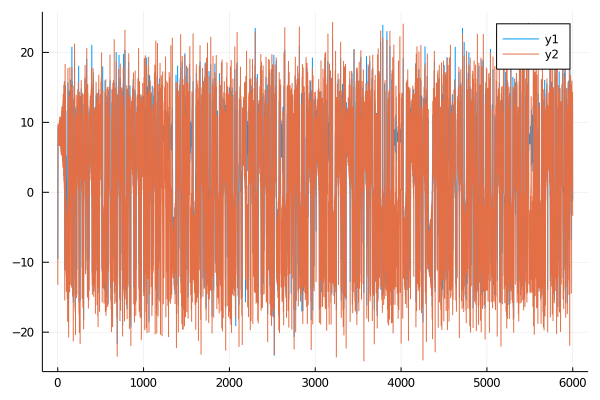

In [23]:
plot(mean_hist(statehist)[2,2:end])
plot!(data.xt[2,1:6000])